# HW3 Binomial Tree Method in Option Pricing

## 1 Construct an additive binomial tree to calculate the values of the European Call option and one for the European Put option.

To see the details of implementation, please check binomail.py. Here, the class OptionPricer is a option pricer with Black-Scholes formula, Monte Carlo simulation, Optimal Hedged Monte Carlo, and Binomial Tree method. The following is an example of determined parameters of the underlying asset.

In [1]:
from option_pricer import OptionPricer

In [2]:
S0 = 100
K = 100
T = 1
r = 0.04
sigma = 0.3

pricer = OptionPricer(S0,K,T,r,sigma)

In [3]:
pricer.BinomialTreePricer(n=100,option_type='c')

13.7238318861179

In [4]:
pricer.OHMCPricer(n_steps=100,n_trails=1000,option_type='c')

13.89337905508744

In [5]:
pricer.MCPricer(n_steps=100,n_trails=1000,option_type='c')

14.650401282701075

In [6]:
pricer.BlackScholesPricer(option_type='c')

13.753264647243569

## 2 Download Option prices (you can use the Bloomberg Terminal, Yahoo! Finance, etc.) for an equity, for 3 different maturities (1 month, 2 months, and 3 months) and 20 strike prices. 

For each strike price in the data, calculate the corresponding implied volatility. You may use the data and calculations you have done for Homework 1. Also use the current short-term interest rate. Calculate the option prices (European Calls and Puts) using the binomial tree, and compare the results with the same prices obtained applying the Black{Scholes formula. Use at least 200 steps in your construction.

In [130]:
from yahoo_options import get_option_yahoo
from datetime import datetime

In [131]:
one_month_expired = datetime(2018,7,20)
two_months_expired = datetime(2018,8,17)
three_months_expired = datetime(2018,9,21)

In [396]:
spy_call_df1, spy_put_df1, spy_quote1 = get_option_yahoo("SPY",one_month_expired)

In [397]:
spy_call_df2, spy_put_df2, spy_quote2 = get_option_yahoo("SPY",two_months_expired)

In [398]:
spy_call_df3, spy_put_df3, spy_quote3 = get_option_yahoo("SPY",three_months_expired)

In [50]:
spy_quote1.ytdReturn/100 # interest rate using year-to-date return

0.019799999999999998

### Calculate implied volatility

In [133]:
import scipy as sp
import scipy.stats
import numpy as np

def BlackSholesPrice(S,K,T,r,sigma):
    d1 = (np.log(S/K) + r*T + sigma**2*T/2)/sigma/np.sqrt(T)
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S*sp.stats.norm.cdf(d1) - np.exp(-r*T)*K*sp.stats.norm.cdf(d2)
    put_price = call_price + np.exp(-r*T)*K - S
       
    return call_price,put_price

def bisection(func,interval,tol):
    a,b = interval
    c = (a+b)/2.
    if func(a)*func(b)>0:
        print("warning: fun(a)*fun(b)>0")
#     func(a) - func(b)
    while(b-a>tol):
        if func(c) == 0:
            return c
        elif func(a)*func(c)<0:
            b=c
        else:
            a=c
        c = (a+b)/2.
    return c

def impliedvol(S,K,T,r,price,option_type):
    if(option_type=="c"):
        price_equation = lambda sigma: BlackSholesPrice(S,K,T,r,sigma)[0] - price
    elif(option_type=="p"):
        price_equation = lambda sigma: BlackSholesPrice(S,K,T,r,sigma)[1] - price
        
    imp_vol = bisection(price_equation,(-1,2),1e-6)
    return imp_vol

def calculate_IV_for_quotes(option_df,quote_series,option_type):
    S = float(quote_series["regularMarketPrice"])
    t0 = spy_time = int(quote_series["regularMarketTime"])
    t1 = int(option_df["expiration"][0])
#     print(t1)
    T = (t1-t0)/3600/24/365
    r = quote_series.ytdReturn/100
    
    def calc_iv(row):
        price = (float(row["bid"])+float(row["ask"]))/2
        K = float(row["strike"])
        return impliedvol(S,K,T,r,price,option_type)
    def calc_price(row):
        price = (float(row["bid"])+float(row["ask"]))/2
        return price
        
    option_df["my_iv"] = option_df.apply(calc_iv,axis=1)
    option_df["time_to_maturity"] = np.array([T]*len(option_df))
    option_df["days_count"] = np.array((t1-t0)/3600/24)
    option_df["average_price"] = option_df.apply(calc_price,axis=1)
    option_df["underlying_price"] = [S]*len(option_df)
    option_df["ytd_rate"] = [r]*len(option_df)
    return option_df

In [137]:
spy_call_df1 = calculate_IV_for_quotes(spy_call_df1,spy_quote1,'c')
spy_call_neat_eu_df1 = spy_call_df1[["contractSymbol",'ask',"bid","average_price","underlying_price","strike","time_to_maturity","ytd_rate","my_iv"]]

In [138]:
spy_call_df2 = calculate_IV_for_quotes(spy_call_df2,spy_quote2,'c')
spy_call_neat_eu_df2 = spy_call_df2[["contractSymbol",'ask',"bid","average_price","underlying_price","strike","time_to_maturity","ytd_rate","my_iv"]]

In [139]:
spy_call_df3 = calculate_IV_for_quotes(spy_call_df3,spy_quote3,'c')
spy_call_neat_eu_df3 = spy_call_df3[["contractSymbol",'ask',"bid","average_price","underlying_price","strike","time_to_maturity","ytd_rate","my_iv"]]

### Take spy_call_neat_df1 as an example

In [140]:
spy_call_neat_eu_df1.head()

,contractSymbol,ask,bid,average_price,underlying_price,strike,time_to_maturity,ytd_rate,my_iv
0,SPY180706C00230000,41.65,41.39,41.52,270.9,230.0,0.006278,0.0198,1.291108e+00
1,SPY180706C00240000,32.56,32.24,32.40,270.9,240.0,0.006278,0.0198,1.281707e+00
2,SPY180706C00245000,25.92,25.36,25.64,270.9,245.0,0.006278,0.0198,1.192093e-07
3,SPY180706C00250000,20.73,20.43,20.58,270.9,250.0,0.006278,0.0198,1.192093e-07
4,SPY180706C00252000,18.75,18.43,18.59,270.9,252.0,0.006278,0.0198,1.192093e-07


In [141]:
import binomial

In [142]:
def binomial_call(row):
    S = row['underlying_price']
    T = row['time_to_maturity']
    K = row['strike']
    r = row['ytd_rate']
    sigma = row['my_iv']
    
    return binomial.call(S=S,K=K,t=T,r=r,sigma=sigma,n=200)

def binomial_put(row):
    S = row['underlying_price']
    T = row['time_to_maturity']
    K = row['strike']
    r = row['ytd_rate']
    sigma = row['my_iv']
    
    return binomial.put(S=S,K=K,t=T,r=r,sigma=sigma,n=200)

def blacksholes_call(row):
    S = row['underlying_price']
    T = row['time_to_maturity']
    K = row['strike']
    r = row['ytd_rate']
    sigma = row['my_iv']
    
    return BlackSholesPrice(S=S,K=K,T=T,r=r,sigma=sigma)[0]

def blacksholes_put(row):
    S = row['underlying_price']
    T = row['time_to_maturity']
    K = row['strike']
    r = row['ytd_rate']
    sigma = row['my_iv']
    
    return BlackSholesPrice(S=S,K=K,T=T,r=r,sigma=sigma)[1]

In [143]:
spy_call_neat_eu_df1['my_binomial_price'] = spy_call_neat_df1.apply(lambda x: binomial_call(x),axis=1)
spy_call_neat_eu_df1['my_blacksholes_price'] = spy_call_neat_df1.apply(lambda x: blacksholes_call(x),axis=1)

/Users/xiayuxuan/Codes/Python/CourseProjects/621/HW2/binomial.py:70: RuntimeWarning: overflow encountered in double_scalars
  (q * opt_val[i + 1, j] + (1 - q) * opt_val[i + 1, j + 1]) \
/Users/xiayuxuan/Codes/Python/CourseProjects/621/HW2/binomial.py:70: RuntimeWarning: invalid value encountered in double_scalars
  (q * opt_val[i + 1, j] + (1 - q) * opt_val[i + 1, j + 1]) \
/Users/xiayuxuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/xiayuxuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

### Calculate option price using black-scholes formula and binomial tree method.

In [145]:
spy_call_neat_eu_df1.sample(10) # Randomly select 20 samples to compare results

,contractSymbol,ask,bid,average_price,underlying_price,strike,time_to_maturity,ytd_rate,my_iv,my_binomial_price,my_blacksholes_price
48,SPY180706C00282000,0.01,0.00,0.005,270.9,282.0,0.006278,0.0198,1.898497e-01,0.004854,0.005000
23,SPY180706C00267500,3.58,3.41,3.495,270.9,267.5,0.006278,0.0198,1.053408e-01,3.494993,3.494999
20,SPY180706C00265000,5.86,5.61,5.735,270.9,265.0,0.006278,0.0198,1.192093e-07,NaN,5.932941
13,SPY180706C00259000,11.94,11.38,11.660,270.9,259.0,0.006278,0.0198,1.192093e-07,NaN,11.932195
56,SPY180706C00288000,0.01,0.01,0.010,270.9,288.0,0.006278,0.0198,2.978061e-01,0.009824,0.010000
25,SPY180706C00269000,2.38,2.31,2.345,270.9,269.0,0.006278,0.0198,1.316594e-01,2.345325,2.345001
65,SPY180706C00305000,0.01,0.00,0.005,270.9,305.0,0.006278,0.0198,5.044671e-01,0.004739,0.005000
10,SPY180706C00257000,14.44,14.26,14.350,270.9,257.0,0.006278,0.0198,4.924122e-01,14.350801,14.350000
24,SPY180706C00268000,3.16,3.08,3.120,270.9,268.0,0.006278,0.0198,1.257020e-01,3.120360,3.120001
3,SPY180706C00250000,20.73,20.43,20.580,270.9,250.0,0.006278,0.0198,1.192093e-07,NaN,20.931077


### Conclusion: Binomial tree method works well when implied volatility is not too small (bad liquidity condition).

## 3 Compute and plot the absolute error

In [72]:
# At the money option
S = 100
K_list = [60, 100, 130] # ITM, ATM, OTM
T = 1
r = 0.05
sigma = 0.4

In [69]:
N_list = [50*i for i in range(1,9)]

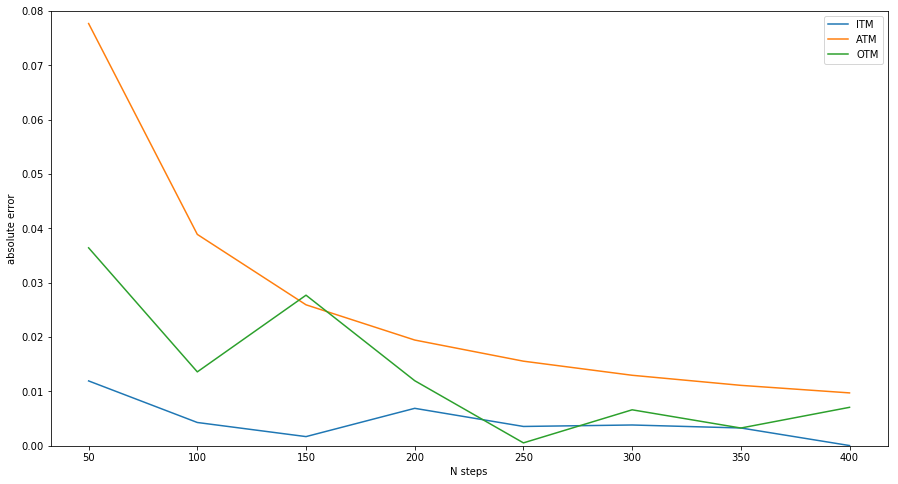

In [100]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(15,8))
title_list = ["ITM","ATM","OTM"]
ax = plt.subplot()
for i,K in enumerate(K_list):
    pricer = OptionPricer(S,K,T,r,sigma)
    err_list = []
    for j,N in enumerate(N_list):
        bs_price = pricer.BlackScholesPricer(option_type='c')
        binomial_price = pricer.BinomialTreePricer(option_type='c',n=N)
        err_list.append(np.abs(bs_price - binomial_price))
    
    
#     ax = plt.subplot(3,1,i+1)
    ax.plot(N_list,err_list,label=title_list[i])
    plt.xlabel('N steps')
    plt.ylabel('absolute error')
#     plt.title(title_list[i])
    plt.ylim(0,0.08)
    plt.legend()
        
        

# plt.tight_layout()        
plt.show()
        
        

### Conclusion: The absolute error tend to decrease as the number of steps goes up. The tendency is significant when option is at the money.

## 4 Implement an additive binomial tree to calculate the American option, both Call and Put. Repeat the steps in part 2) and calculate the respective option prices as if they are American.


Here, we used implied volatility from the raw data fetched from Yahoo finance, as it is supposed to be the american options' implied volatility. Not the toy European ones we calculated in problem 2. So, actually in problem 2, the column "my_iv" is not implied by market price, but obtained by assumming the American option prices as European ones.

In [102]:
spy_call_df1.head()

,ask,bid,change,contractSize,contractSymbol,currency,expiration,impliedVolatility,inTheMoney,lastPrice,...,percentChange,strike,volume,my_iv,time_to_maturity,days_count,average_price,underlying_price,three_months_rate,ytd_rate
0,41.65,41.39,0.000000,REGULAR,SPY180706C00230000,USD,1530835200,1.394534,True,43.00,...,0.000000,230.0,2,1.291108e+00,0.006278,2.291644,41.52,270.9,0.0198,0.0198
1,32.56,32.24,0.000000,REGULAR,SPY180706C00240000,USD,1530835200,1.378909,True,33.39,...,0.000000,240.0,2,1.281707e+00,0.006278,2.291644,32.40,270.9,0.0198,0.0198
2,25.92,25.36,0.959999,REGULAR,SPY180706C00245000,USD,1530835200,0.539067,True,27.00,...,3.686632,245.0,5,1.192093e-07,0.006278,2.291644,25.64,270.9,0.0198,0.0198
3,20.73,20.43,-2.449999,REGULAR,SPY180706C00250000,USD,1530835200,0.000010,True,20.60,...,-10.629063,250.0,95,1.192093e-07,0.006278,2.291644,20.58,270.9,0.0198,0.0198
4,18.75,18.43,0.000000,REGULAR,SPY180706C00252000,USD,1530835200,0.000010,True,18.34,...,0.000000,252.0,11,1.192093e-07,0.006278,2.291644,18.59,270.9,0.0198,0.0198


In [120]:
def binomial_am_call(row):
    S = row['underlying_price']
    T = row['time_to_maturity']
    K = row['strike']
    r = row['ytd_rate']
    sigma = row['impliedVolatility']
    if(sigma<1e-4):
        return float("nan")
    return binomial.call(S=S,K=K,t=T,r=r,sigma=sigma,am=True,n=200)

def binomial_am_put(row):
    S = row['underlying_price']
    T = row['time_to_maturity']
    K = row['strike']
    r = row['ytd_rate']
    sigma = row['impliedVolatility']
    if(sigma<1e-4):
        return float("nan")
    return binomial.put(S=S,K=K,t=T,r=r,sigma=sigma,am=True,n=200)

In [117]:
spy_call_df3 = calculate_IV_for_quotes(spy_call_df3,spy_quote3,'c')
spy_call_neat_df3 = spy_call_df3[["contractSymbol",'ask',"bid","average_price","underlying_price","strike","time_to_maturity","ytd_rate","my_iv"]]

In [118]:
spy_put_df3 = calculate_IV_for_quotes(spy_put_df3,spy_quote3,'p')
spy_put_neat_df3 = spy_put_df3[["contractSymbol",'ask',"bid","average_price","underlying_price","strike","time_to_maturity","ytd_rate","my_iv"]]

In [119]:


spy_call_am_neat_df3 = spy_call_df3[["contractSymbol",'ask',"bid","average_price",\
                                     "underlying_price","strike","time_to_maturity",\
                                     "ytd_rate","impliedVolatility"]]
spy_put_am_neat_df3 = spy_put_df3[["contractSymbol",'ask',"bid","average_price",\
                                     "underlying_price","strike","time_to_maturity",\
                                     "ytd_rate","impliedVolatility"]]

In [122]:
spy_call_am_neat_df3["my_am_price"] = spy_call_am_neat_df3.apply(lambda x: binomial_am_call(x),axis=1)
spy_put_am_neat_df3["my_am_price"] = spy_put_am_neat_df3.apply(lambda x: binomial_am_put(x),axis=1)


/Users/xiayuxuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/xiayuxuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [123]:
spy_call_am_neat_df3 = spy_call_am_neat_df3.dropna(axis=0) # drop the abnormal values
spy_put_am_neat_df3 = spy_put_am_neat_df3.dropna(axis=0) # drop the abnormal values

In [126]:
spy_call_am_neat_df3.sample(10) # randomly select 10 samples

,contractSymbol,ask,bid,average_price,underlying_price,strike,time_to_maturity,ytd_rate,impliedVolatility,my_am_price
35,SPY180706C00274500,0.10,0.09,0.095,270.9,274.5,0.006278,0.0198,0.129403,0.133570
58,SPY180706C00290000,0.02,0.01,0.015,270.9,290.0,0.006278,0.0198,0.378912,0.033331
42,SPY180706C00278000,0.01,0.00,0.005,270.9,278.0,0.006278,0.0198,0.148446,0.016184
48,SPY180706C00282000,0.01,0.00,0.005,270.9,282.0,0.006278,0.0198,0.218758,0.016896
53,SPY180706C00286000,0.01,0.00,0.005,270.9,286.0,0.006278,0.0198,0.289070,0.019144
6,SPY180706C00253000,21.10,20.91,21.005,270.9,253.0,0.006278,0.0198,1.227299,21.531186
49,SPY180706C00282500,0.01,0.00,0.005,270.9,282.5,0.006278,0.0198,0.226570,0.016580
63,SPY180706C00300000,0.01,0.00,0.005,270.9,300.0,0.006278,0.0198,0.500005,0.017645
27,SPY180706C00270500,1.39,1.34,1.365,270.9,270.5,0.006278,0.0198,0.147469,1.490093
10,SPY180706C00257000,14.44,14.26,14.350,270.9,257.0,0.006278,0.0198,0.536137,14.507299


In [127]:
spy_put_am_neat_df3.sample(10) # randomly select 10 samples

,contractSymbol,ask,bid,average_price,underlying_price,strike,time_to_maturity,ytd_rate,impliedVolatility,my_am_price
61,SPY180706P00285000,14.67,14.32,14.495,270.9,285.0,0.006278,0.0198,0.548344,14.798868
34,SPY180706P00269000,0.79,0.76,0.775,270.9,269.0,0.006278,0.0198,0.195565,0.878327
35,SPY180706P00270000,1.10,1.07,1.085,270.9,270.0,0.006278,0.0198,0.188729,1.192342
44,SPY180706P00274500,4.18,3.89,4.035,270.9,274.5,0.006278,0.0198,0.229500,4.255673
62,SPY180706P00286000,15.67,15.32,15.495,270.9,286.0,0.006278,0.0198,0.523442,15.592315
31,SPY180706P00267000,0.38,0.35,0.365,270.9,267.0,0.006278,0.0198,0.207039,0.450619
59,SPY180706P00283000,12.24,12.04,12.140,270.9,283.0,0.006278,0.0198,0.352546,12.271653
18,SPY180706P00256000,0.02,0.01,0.015,270.9,256.0,0.006278,0.0198,0.324226,0.032240
56,SPY180706P00281000,10.70,10.15,10.425,270.9,281.0,0.006278,0.0198,0.442877,10.820069
5,SPY180706P00240000,0.01,0.00,0.005,270.9,240.0,0.006278,0.0198,0.562504,0.010970


## 5 Create a table which contains the following columns: Bid and Ask values, Black Scholes price, European and American prices calculated using the binomial tree. Then write comments about the observed differences between the various option valuations and how they compare with the actual bid/ask values.

### The question is self-contradictory. The price we fetched from Yahoo finance is predetermined as American or European type, can't be fetched simoutenously. So the result is shown as what we discussed in problem 2 and 4. 

In [149]:
spy_call_neat_eu_df1.dropna(axis=0).sample(10)[["bid","ask","my_blacksholes_price","my_binomial_price"]]

,bid,ask,my_blacksholes_price,my_binomial_price
7,23.69,23.97,23.830000,23.843800
49,0.00,0.01,0.005000,0.004815
52,0.00,0.01,0.005000,0.004887
59,0.00,0.01,0.005000,0.004761
47,0.00,0.01,0.005000,0.004907
63,0.00,0.01,0.005000,0.004858
41,0.00,0.01,0.005000,0.004879
66,0.00,0.01,0.005000,0.004763
5,21.40,21.62,21.510001,21.516360
54,0.00,0.01,0.005000,0.004899


In [150]:
spy_call_am_neat_df3.sample(10)[["bid","ask","my_am_price"]]

,bid,ask,my_am_price
48,0.00,0.01,0.016896
60,0.00,0.01,0.018676
41,0.00,0.01,0.017084
12,12.37,12.94,12.993214
36,0.06,0.07,0.096962
16,8.41,8.97,9.029991
0,41.39,41.65,41.770250
5,21.40,21.62,22.041314
49,0.00,0.01,0.016580
24,3.08,3.16,3.240380


## 6 Using the binomial tree for American Calls and Puts, calculate the implied volatility corresponding to the data you have downloaded in part (2). You will need to use the bisection or Newton/secant method of finding roots with the respective binomial trees. Compare these values of the implied volatility with the volatilities from Homework 1. Write detailed observations.

See problem 1-5, especially problem 2. Since in the Yahoo finance, we can only obtain the American type option for SPY, as it is has more liquidity. On the other hand, calculting implied volatility for American option is not effective using binomial simulation method, so we only apply the root finding method to the European type option we assumed in problem 2, but there is no market values as comparison as we discussed in Problem 5. The result is shown as the following.

In [153]:
spy_call_neat_eu_df1.sample(10)

,contractSymbol,ask,bid,average_price,underlying_price,strike,time_to_maturity,ytd_rate,my_iv,my_binomial_price,my_blacksholes_price
21,SPY180706C00266000,4.92,4.70,4.810,270.9,266.0,0.006278,0.0198,1.192093e-07,NaN,4.933065
52,SPY180706C00285000,0.01,0.00,0.005,270.9,285.0,0.006278,0.0198,2.342292e-01,0.004887,0.005000
13,SPY180706C00259000,11.94,11.38,11.660,270.9,259.0,0.006278,0.0198,1.192093e-07,NaN,11.932195
17,SPY180706C00262500,8.29,8.00,8.145,270.9,262.5,0.006278,0.0198,1.192093e-07,NaN,8.432630
59,SPY180706C00291000,0.01,0.00,0.005,270.9,291.0,0.006278,0.0198,3.193897e-01,0.004761,0.005000
2,SPY180706C00245000,25.92,25.36,25.640,270.9,245.0,0.006278,0.0198,1.192093e-07,NaN,25.930455
60,SPY180706C00292500,0.01,0.00,0.005,270.9,292.5,0.006278,0.0198,3.400513e-01,0.004809,0.005000
35,SPY180706C00274500,0.10,0.09,0.095,270.9,274.5,0.006278,0.0198,1.183792e-01,0.094378,0.094999
18,SPY180706C00263000,7.80,7.51,7.655,270.9,263.0,0.006278,0.0198,1.192093e-07,NaN,7.932693
55,SPY180706C00287500,0.01,0.00,0.005,270.9,287.5,0.006278,0.0198,2.702380e-01,0.004892,0.005000


## 7 Implement a trinomial tree to price an American Put option. Hint. See Chapter 3 in [1]. Use the trinomial tree with the data in this problem and compare with the results obtained using the binomial tree.

In [159]:
# At the money option
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.4

In [158]:
import trinomial

In [161]:
trinomialt_result = trinomial.american_pricer(S=S,K=K,T=T,r=r,sigma=sigma,call=False).price(N=200)

In [163]:
binomial_result = binomial.put(S=S,K=K,t=T,r=r,sigma=sigma,n=200)

In [166]:
print("Binomial Put: {}\nTrinomial Put: {}".format(trinomialt_result,binomial_result))

Binomial Put: 13.660241287601293
Trinomial Put: 13.12643722498959


## 8 Construct a binomial tree to calculate the price of an European Up-and-Out call option. Use S0 = 10, strike K = 10, maturity T = 0.3, volatility $\sigma$= 0.2, short rate r = 0.01, dividends d = 0, and barrier H = 11. Use as many steps in your tree as you think are necessary. Hint. Read the algorithm in the book [1] and try and figure out how to modify the code there to work with the new option.

In [301]:
import math
def up_and_out_option(S, K, t, r, sigma, H, div=0, call=1, n=100, am=False):
    """
    Price an option using the Binomial Options Pricing model
    S: initial spot price of stock
    K: strick price of option
    sigma: volatility
    r: risk-free interest rate
    t: time to maturity (in years)
    div: dividend yield (continuous compounding)
    call: 1 if call option, -1 if put
    n: binomial steps
    am: True for American option, False for European option
    """
    delta = float(t) / n
    u = math.exp(sigma * math.sqrt(delta))
    d = float(1) / u
    q = float((math.exp((r - div) * delta) - d)) / (u - d)  # Prob. of up step
    stock_val = np.zeros((n + 1, n + 1))
    opt_val = np.zeros((n + 1, n + 1))

    # Calculate stock value at maturity
    stock_val[0, 0] = S
    for i in range(1, n + 1):
        stock_val[i, 0] = stock_val[i - 1, 0] * u
        for j in range(1, i + 1):
            stock_val[i, j] = stock_val[i - 1, j - 1] * d

    # Recursion for option price
    for j in range(n + 1):
        if(np.array(stock_val[n,j])<H):
#             print("ddddsssaa")
            opt_val[n, j] = max(0, call*(stock_val[n, j] - K))
        else:
            opt_val[n, j] = 0
            
#     for j in range(n + 1):
#         if(stock_val[n, j]>H):
#             opt_val[n,j] = 0
#         else:
#             opt_val[n, j] = max(0, call*(stock_val[n, j] - K))
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            opt_val[i, j] = \
                (q * opt_val[i + 1, j] + (1 - q) * opt_val[i + 1, j + 1]) \
                / math.exp(r * delta)
                
            if(stock_val[i,j]>H):
                opt_val[i,j] = 0
            if am:
                opt_val[i, j] = max(opt_val[i, j], call*(stock_val[i, j] - K))
#     print(stock_val[:,:])
    return opt_val[0, 0]


In [302]:
S0 = 10
K = 10
H = 11
r = 0.01
sigma = 0.2
T = 0.3

In [303]:
up_and_out_option(S=S0,K=K,t=T,r=r,sigma=sigma,H=H,am=False,n=100)

0.058303299666453035

## 9 To price the European Up-and-Out Call option, explicit formulae can be found. Implement the formula (5.2) from [2] and compare your results with part (1). Use the same parameters as before. What do you observe?

In [207]:
def blacksholes(S,K,T,r,sigma,option_type='c'):
        d1 = (np.log(S/K)+r*T +0.5*sigma**2*T)/(sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        N = lambda x: sp.stats.norm.cdf(x)
        call = S * N(d1) - np.exp(-r*T) * K * N(d2)
        put = call - S + K*np.exp(-r*T)
        if(option_type=="c"):
            return call
        elif(option_type=="p"):
            return put
        else:
            print("please enter the option type: (c/p)")
        pass
    
def d1(S,K,T,r,sigma):
    return (np.log(S/K)+r*T +0.5*sigma**2*T)/(sigma*np.sqrt(T))

def d2(S,K,T,r,sigma):
    _d1 = d1(S,K,T,r,sigma)
    return _d1 - sigma*np.sqrt(T)

N = lambda x: sp.stats.norm.cdf(x)

In [262]:
def up_and_out_call_formula(S,K,T,r,sigma,H):
    CSK = blacksholes(S,K,T,r,sigma)
    CSH = blacksholes(S,H,T,r,sigma)
    dHS = d1(H,S,T,r,sigma)
    dSH = d1(S,H,T,r,sigma)
#     d2SH = d2(S,H,T,r,sigma)
#     Cd = np.exp(-r*T)*N(d2SH)
    v = r - sigma**2/2
    UO = CSK - CSH - (H-K)*np.exp(-r*T)*N(dSH)\
        - (H/S)**(2*v/sigma**2)* (blacksholes(H**2/S,K,T,r,sigma) - blacksholes(H**2/S,H,T,r,sigma)\
                                 - (H-K)*np.exp(-r*T)* N(dHS))
    return UO
    
def up_and_out_call_formula2(S,K,T,r,sigma,H):
    
    lbd = (r+sigma**2/2)/sigma**2
    x1 = np.log(S/H)/(sigma*np.sqrt(T)) + lbd*sigma*np.sqrt(T)
    y1 = np.log(H/S)/(sigma*np.sqrt(T)) + lbd*sigma*np.sqrt(T)
    y = np.log(H**2/(S*K))/(sigma*np.sqrt(T)) + lbd*sigma*np.sqrt(T)
    _d1 = d1(S,K,T,r,sigma)
    _d2 = d2(S,K,T,r,sigma)
#     print(lbd,x1,y1,_d1,_d2,N(_d1))
    UO = S*(N(_d1)-N(x1)+(H/S)**(2*lbd)*(N(-y)-N(-y1)))\
            + K*np.exp(-r*T)*(-N(_d2)+N(x1-sigma*np.sqrt(T))\
                          - (H/S)**(2*lbd-2)*(N(-y+sigma*np.sqrt(T))\
                                              - N(-y1+sigma*np.sqrt(T))))
    return UO

In [304]:
def compare_up_and_out(S0,K,T,r,sigma,H):
    bino = up_and_out_option(S=S0,K=K,t=T,r=r,sigma=sigma,H=H,n=400)
    formu = up_and_out_call_formula(S=S0,K=K,T=T,r=r,sigma=sigma,H=H)
    formu2 = up_and_out_call_formula2(S=S0,K=K,T=T,r=r,sigma=sigma,H=H)
    print("binomial price: {}\nformula price1: {}\nformula price2: {}".format(bino,formu,formu2))

In [305]:
compare_up_and_out(10,10,T,r,sigma,11)

binomial price: 0.05822870843673515
formula price1: 0.05031730744120267
formula price2: 0.05309279660325128


### Conclusion: This problem need more discussion. 
* The formula you provided is slightly wrong as it can obtain negative price. Should use up_and_out_call_formula2 instead.
* Binomial tree can easily price path dependend option, but in this algorithm, might be too naive to conclude it is proper to do so. From the result, we can see compared to the theoretical value (formula2), it has quite a lot error. Since up-and-out option pricing should consider the history of past trajectory, it is not good to only consider the current situation, thus Monte Carlo simulation is more proper in this case, or using more complicated binomial algorithm

## 10 Price an European Up-and-In call option, using the same parameters as before. Hint. Two methods can be employed: the analytical solution in (5.1) or the In-Out parity. Use both methods in order to verify your results.

In [306]:
def up_and_in_call_formula2(S,K,T,r,sigma,H):
    call_price = blacksholes(S,K,T,r,sigma)
    up_and_out_call_price = up_and_out_call_formula2(S,K,T,r,sigma,H)
    return call_price - up_and_out_call_price

In [308]:
print("Using in-out parity, the price of up-and-in call option: {}".format(up_and_in_call_formula2(S0,K,T,r,sigma,H)))

Using in-out parity, the price of up-and-in call option: 0.3981948482776474


## 10 Construct a binomial tree to calculate the price of an American Up-and-In call option.

In [330]:
def up_and_in_option(S, K, t, r, sigma, H, div=0, call=1, n=100, am=False):
    """
    Price an option using the Binomial Options Pricing model
    S: initial spot price of stock
    K: strick price of option
    sigma: volatility
    r: risk-free interest rate
    t: time to maturity (in years)
    div: dividend yield (continuous compounding)
    call: 1 if call option, -1 if put
    n: binomial steps
    am: True for American option, False for European option
    """
    delta = float(t) / n
    u = math.exp(sigma * math.sqrt(delta))
    d = float(1) / u
    q = float((math.exp((r - div) * delta) - d)) / (u - d)  # Prob. of up step
    stock_val = np.zeros((n + 1, n + 1))
    opt_val = np.zeros((n + 1, n + 1))

    # Calculate stock value at maturity
    stock_val[0, 0] = S
    for i in range(1, n + 1):
        stock_val[i, 0] = stock_val[i - 1, 0] * u
        for j in range(1, i + 1):
            stock_val[i, j] = stock_val[i - 1, j - 1] * d

    # Recursion for option price
    for j in range(n + 1):
        if(np.array(stock_val[n,j])>H):
            opt_val[n, j] = max(0, call*(stock_val[n, j] - K))
        else:
            opt_val[n, j] = 0
            
#     for j in range(n + 1):
#         if(stock_val[n, j]>H):
#             opt_val[n,j] = 0
#         else:
#             opt_val[n, j] = max(0, call*(stock_val[n, j] - K))
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            opt_val[i, j] = \
                (q * opt_val[i + 1, j] + (1 - q) * opt_val[i + 1, j + 1]) \
                / math.exp(r * delta)
                
            if(stock_val[i,j]<H):
                opt_val[i,j] = 0
            if am:
                opt_val[i, j] = max(opt_val[i, j], call*(stock_val[i, j] - K))
#     print(opt_val[:,:])
    return opt_val[0, 0]


In [331]:
print("The price of up-and-in American call option: {}".format(up_and_in_option(S0,K,T,r,sigma,H,n=400,am=True)))

The price of up-and-in American call option: 0.0


## 11 Adapting the Binomial tree to time varying (deterministic) coefficients (20 points). Please refer to Section 2.9 in [1]. Consider the following model for $X_t = log S_t$ the logarithm of the stock value:
$$d X_t = v_t dt + \sigma_t dW_t$$
where $v_t = r_t - \frac{\sigma_t^2}{2}$. This model is under the equivalent martingale measure. Assume that the interest rate and volatility functions evolve according to:
$$r_t = 0.05(1+0.01t)$$
$$\sigma_t = 0.3(1+0.005t)$$

### Scheme 1: Binomial Tree of the Underlying Price:

In [403]:
def time_deterministic_option(S, K, sigma_fun, r_fun, T, div=0, call=1, n=100, am=False,display=False):
    """
    Price an option using the Binomial Options Pricing model
    S: initial spot price of stock
    K: strick price of option
    sigma: volatility
    r: risk-free interest rate
    t: time to maturity (in years)
    div: dividend yield (continuous compounding)
    call: 1 if call option, -1 if put
    n: binomial steps
    am: True for American option, False for European option
    """
    delta = float(T) / n
    t_array = np.arange(n+1)*delta
    r_array = r_fun(t_array)
    sigma_array = sigma_fun(t_array)
    v_array = r_array - sigma_array**2/2
    
    r = r_array[0]
    sigma = sigma_array[0]
    u = math.exp(sigma * math.sqrt(delta))
    d = float(1) / u
    q = float((math.exp((r - div) * delta) - d)) / (u - d)  # Prob. of up step
    
    u_array = np.exp(sigma_array*math.sqrt(delta))
    d_array = 1.0/u_array
    q_array = (np.exp((r-div)*delta) - d_array)/(u_array-d_array)
    
#     u_array = u*np.ones(len(t_array))
#     d_array = d*np.ones(len(t_array))
#     q_array = q*np.ones(len(t_array))
    
    stock_val = np.zeros((n+1,n+1))
    opt_val = np.zeros((n+1,n+1))
    stock_val[0,0] = S
    for i in range(1,n+1):
        stock_val[i,0] = stock_val[i-1,0]*u_array[i]
        for j in range(1,i+1):
            stock_val[i,j] = stock_val[i-1,j-1]*d_array[i]
    for j in range(n+1):
        opt_val[n,j] = max(0,call*(stock_val[n,j]-K))
    for i in range(n-1,-1,-1):
        for j in range(i+1):
            opt_val[i,j] = (q_array[i]*opt_val[i+1,j]+(1-q_array[i])*opt_val[i+1,j+1])\
            /math.exp(r_array[i]*delta)
            if(am):
                opt_val[i,j] = max(opt_val[i,j],call*(stock_val[i,j]-K))
#     print(u,u_array)
#     print(d,d_array)
#     print(q,q_array)
    if(display):
        print("rt: {}\nsigmat: {}\nvt: {}\npt: {}".format(r_array,sigma_array,v_array,q_array))
        print("******************************************************************************")
    return opt_val[0,0]

In [404]:
r_fun = lambda x: 0.05*(1+0.01*x)
sigma_fun = lambda x: 0.3*(1+0.005*x)
time_deterministic_option(S=10,K=10,T=0.5,n=11,r_fun=r_fun, sigma_fun=sigma_fun,display=True)

rt: [ 0.05        0.05002273  0.05004545  0.05006818  0.05009091  0.05011364
  0.05013636  0.05015909  0.05018182  0.05020455  0.05022727  0.05025   ]
sigmat: [ 0.3         0.30006818  0.30013636  0.30020455  0.30027273  0.30034091
  0.30040909  0.30047727  0.30054545  0.30061364  0.30068182  0.30075   ]
vt: [ 0.005       0.00500227  0.00500454  0.0050068   0.00500905  0.00501131
  0.00501355  0.0050158   0.00501803  0.00502027  0.00502249  0.00502472]
pt: [ 0.5017902   0.50178253  0.50177486  0.50176719  0.50175952  0.50175185
  0.50174418  0.50173652  0.50172886  0.5017212   0.50171354  0.50170588]
******************************************************************************


0.9809325162400121

### Scheme 2: Binomial Tree of the Log Underlying Price:

$$
\begin{cases}
      p_u \Delta x_u + p_d \Delta x_d &= (r-\frac{\sigma^2}{2})\Delta t \\
      p_u \Delta x_u^2 + p_d \Delta x_d^2  &= \sigma^2 \Delta t + (r-\frac{\sigma^2}{2})^2\Delta t^2\\
      p_u + p_d &= 1
    \end{cases}
$$

Considering the recombining feature, a popular choice is $\Delta x_u = \Delta x_d = \Delta x$. By substitution, it would yield:
$$\Delta x = \sqrt{(r-\frac{\sigma^2}{2})^2 \Delta t^2 + \sigma^2 \Delta t}$$
$$p_u = \frac{1}{2}+ \frac{1}{2} \frac{(r - \frac{\sigma^2}{2})\Delta t}{\Delta x}$$

In [405]:
def time_deterministic_option2(S, K, sigma_fun, r_fun, T, div=0, call=1, n=100, am=False,display=False):
    """
    Price an option using the Binomial Options Pricing model
    S: initial spot price of stock
    K: strick price of option
    sigma: volatility
    r: risk-free interest rate
    t: time to maturity (in years)
    div: dividend yield (continuous compounding)
    call: 1 if call option, -1 if put
    n: binomial steps
    am: True for American option, False for European option
    """
    delta = float(T) / n
    t_array = np.arange(n+1)*delta
    r_array = r_fun(t_array)
    sigma_array = sigma_fun(t_array)
    v_array = r_array - sigma_array**2/2
    dx_array = np.sqrt((v_array)**2 * delta**2 + sigma_array**2*delta)
    pu_array = .5+.5*(v_array)*delta/dx_array
    pd_array = 1 - pu_array
    
#     r = r_array[0]
#     sigma = sigma_array[0]
#     u = math.exp(sigma * math.sqrt(delta))
#     d = float(1) / u
#     q = float((math.exp((r - div) * delta) - d)) / (u - d)  # Prob. of up step
    
#     u_array = np.exp(sigma_array*math.sqrt(delta))
#     d_array = 1.0/u_array
#     q_array = (np.exp((r-div)*delta) - d_array)/(u_array-d_array)
    
#     u_array = u*np.ones(len(t_array))
#     d_array = d*np.ones(len(t_array))
#     q_array = q*np.ones(len(t_array))
    
    log_stock_val = np.zeros((n+1,n+1))
    opt_val = np.zeros((n+1,n+1))
    log_stock_val[0,0] = math.log(S)
    for i in range(1,n+1):
        log_stock_val[i,0] = log_stock_val[i-1,0] + dx_array[i-1]
        for j in range(1,i+1):
            log_stock_val[i,j] = log_stock_val[i-1,j-1] - dx_array[i-1]
    for j in range(n+1):
        opt_val[n,j] = max(0,call*(math.exp(log_stock_val[n,j])-K))
    for i in range(n-1,-1,-1):
        for j in range(i+1):
            opt_val[i,j] = (pu_array[i]*opt_val[i+1,j]+pd_array[i]*opt_val[i+1,j+1])\
            /math.exp(r_array[i]*delta)
            if(am):
                opt_val[i,j] = max(opt_val[i,j],call*(math.exp(log_stock_val[i,j])-K))
#     print(u,u_array)
#     print(d,d_array)
#     print(q,q_array)
    if(display):
        print("rt: {}\nsigmat: {}\nvt: {}\npt: {}\ndxt: {}".format(r_array,sigma_array,v_array,pu_array,dx_array))
        print("******************************************************************************")
    return opt_val[0,0]

In [407]:
time_deterministic_option2(S=10,K=10,T=0.5,n=11,r_fun=r_fun, sigma_fun=sigma_fun,display=True)

rt: [ 0.05        0.05002273  0.05004545  0.05006818  0.05009091  0.05011364
  0.05013636  0.05015909  0.05018182  0.05020455  0.05022727  0.05025   ]
sigmat: [ 0.3         0.30006818  0.30013636  0.30020455  0.30027273  0.30034091
  0.30040909  0.30047727  0.30054545  0.30061364  0.30068182  0.30075   ]
vt: [ 0.005       0.00500227  0.00500454  0.0050068   0.00500905  0.00501131
  0.00501355  0.0050158   0.00501803  0.00502027  0.00502249  0.00502472]
pt: [ 0.50177666  0.50177706  0.50177747  0.50177786  0.50177826  0.50177866
  0.50177905  0.50177944  0.50177983  0.50178022  0.50178061  0.50178099]
dxt: [ 0.06396062  0.06397516  0.06398969  0.06400423  0.06401877  0.0640333
  0.06404784  0.06406238  0.06407691  0.06409145  0.06410599  0.06412052]
******************************************************************************


0.98090515246865007

### Note:
Here $\Delta x$ is a time varying variable, and chosen to match the branch points.

### Comparison:
* Constant Parameters
    * Black-Scholes
    * Binomial Tree
* Time Varying Parameters
    * Binomial Tree of the Underlying Price
    * Binomial Tree of the Log Underlying Price

In [408]:
S = 10
K = 10
T = 0.5
r = 0.05
sigma = 0.3
r_fun = lambda x: 0.05*(1+0.01*x)
sigma_fun = lambda x: 0.3*(1+0.005*x)

In [386]:
blacksholes(S=10,K=10,T=0.5,r=0.05,sigma=0.3)

0.96348766284491827

In [387]:
binomial.call(S=10,K=10,t=0.5,r=0.05,sigma=0.3,n=11)

0.98209100747289291

In [410]:
const_BS = blacksholes(S=S,K=K,T=T,r=r,sigma=sigma)
const_binomial = binomial.call(S=S,K=K,t=T,r=r,sigma=sigma,n=11)
time_varying_binomial1 = time_deterministic_option(S=S,K=K,T=T,n=11,r_fun=r_fun, sigma_fun=sigma_fun)
time_varying_binomial2 = time_deterministic_option2(S=S,K=K,T=T,n=11,r_fun=r_fun, sigma_fun=sigma_fun)
print("*************************************")
print("Constant Parameters:")
print("Black-Scholes: {}".format(const_BS))
print("Binomial: {}".format(const_binomial))
print("*************************************")
print("Time-Varying Parameters:")
print("Binomial for Price: {}".format(time_varying_binomial1))
print("Binomial for Log Price: {}".format(time_varying_binomial2))

*************************************
Constant Parameters:
Black-Scholes: 0.9634876628449183
Binomial: 0.9820910074728929
*************************************
Time-Varying Parameters:
Binomial for Price: 0.9809325162400121
Binomial for Log Price: 0.9809051524686501
